In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, RK45, solve_ivp
from scipy.signal import find_peaks

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
plt.style.use('seaborn-whitegrid')

# Question 1

We want to solve 

$$-\frac{\hbar^{2}}{2 m} \frac{d^{2} \psi(x)}{d x^{2}}+V(x) \psi(x)=E \psi(x)$$

with

$$V(x)=\left\{\begin{array}{ll}-V_{0}=-83 \mathrm{MeV} & |x| \leq a=2 \mathrm{fm} \\ 0 & |x|>a=2 \mathrm{fm}\end{array}\right.$$

Which are typical values for a nucleus. 

Using dimensionless wavenumber $k$, where 

$$k^{2}=-\frac{2 m}{\hbar^{2}} E$$

we have the following equations to solve

$$\begin{aligned} \frac{d^{2} \psi}{d x^{2}}+\left(\frac{2 m}{\hbar^{2}} V_{0}-k^{2}\right) \psi(x)=0, &|x| \leq a \\ \frac{d^{2} \psi}{d x^{2}}-k^{2} \psi(x)=0, &|x|>a \end{aligned}$$

If the particle is in a potential well $(-a,a)$, then we know the wave function decays exponentially to the right and left. So we have the following boundary conditions

$$\begin{array}{l}\psi(x) \rightarrow \psi_{R}(x)=e^{-k x}, \quad x \rightarrow+\infty \\ \psi(x) \rightarrow \psi_{L}(x)=e^{k x}, \quad x \rightarrow-\infty\end{array}$$

Problem: we need to find (numerically) the value of $k^{2}$ (proportional to the energy $E$) that gives a continuum function smoothly connecting $\psi_{L}$ to $\psi_{R}$

We are looking to minimize the error at the matching point, defined as $\epsilon$, where

$$\epsilon=\frac{\psi_{L}^{\prime}\left(x_{m}\right) / \psi_{L}\left(x_{m}\right)-\psi_{R}^{\prime}\left(x_{m}\right) / \psi_{R}\left(x_{m}\right)}{\psi_{L}^{\prime}\left(x_{m}\right) / \psi_{L}\left(x_{m}\right)+\psi_{R}^{\prime}\left(x_{m}\right) / \psi_{R}\left(x_{m}\right)}$$

In [2]:
α = 0.0483 # alpha = 2m/h^2  MeV^{-1}fm^{-1} 
a = 2 # fm # 2
V_0 = 83 #Mev 
V = lambda x: V_0 if np.abs(x) <= a else 0

x_max = 5*a # far left and far right point distance
x_m = a # matching point

In [3]:
def get_L_solution(k):
    ψL_far = lambda x, k: np.exp(k*x)
    ψLdx_far = lambda x, k: k*np.exp(k*x)
    
    def deriv(x, y, V, α, k):
        ψ, dψdx = y
        return dψdx, (k**2 - V(x)*α)*ψ

    x_span = (-x_max, x_m)
    y_0 = [ψL_far(-x_max,k), ψLdx_far(-x_max,k)]
    sol = solve_ivp(lambda x,y: deriv(x,y,V,α,k), t_span=x_span, y0=y_0, method="RK45", rtol=1e-8, atol=1e-8)
    x = sol.t
    ψ = sol.y[0]
    dψdx = sol.y[1]
    return x, ψ, dψdx


def get_R_solution(k):
    ψR_far = lambda x, k: np.exp(-k*x)
    ψRdx_far= lambda x, k: -k*np.exp(-k*x)
    
    def deriv(x, y, V, α, k):
        ψ, dψdx = y
        return dψdx, (k**2 - V(x)*α)*ψ

    x_span = (x_max, x_m)
    y_0 = [ψR_far(x_max,k), ψRdx_far(x_max,k)]
    sol = solve_ivp(lambda x,y: deriv(x,y,V,α,k), t_span=x_span, y0=y_0, method="RK45", rtol=1e-8, atol=1e-8)
    x = sol.t
    ψ = sol.y[0]
    dψdx = sol.y[1]
    return x, ψ, dψdx


def get_error(k):
    x_L, ψ_L, dψdx_L = get_L_solution(k)
    x_R, ψ_R, dψdx_R = get_R_solution(k)
    err = (dψdx_L[-1]/ψ_L[-1] - dψdx_R[-1]/ψ_R[-1])/(dψdx_L[-1]/ψ_L[-1] + dψdx_R[-1]/ψ_R[-1])
    return err

In [4]:
n_iter = 10000
k_start = 0
k_max = np.sqrt(α*V_0)
k_list = np.linspace(k_start, k_max, n_iter)
err_list = np.ones((n_iter,))

# Setting the tolerance higher would make the iteration stop at the first local minima
# but here I am setting it super low so that it iterates through all of the local minima 
# in order to see all possible solutions
tol = 0.00001

for i, k in enumerate(k_list):
    err = get_error(k)
    err_list[i] = err
    k_list[i] = k        
    if np.abs(err) < tol:
        E = -(1/α)*k**2
        print("Tolerance reached at k = {} and E = {}".format(np.round(k,5), np.round(E,5)))
        break
        
# print index of minimum absolute value of eplsion
min_idx = np.argmin(np.abs(err_list))
k_min = k_list[min_idx]
print("Optimal k = {} with epsilon = {}".format(np.round(k_min,4), np.round(np.min(np.abs(err_list)), 7)))

Optimal k = 1.5739 with epsilon = 4.75e-05


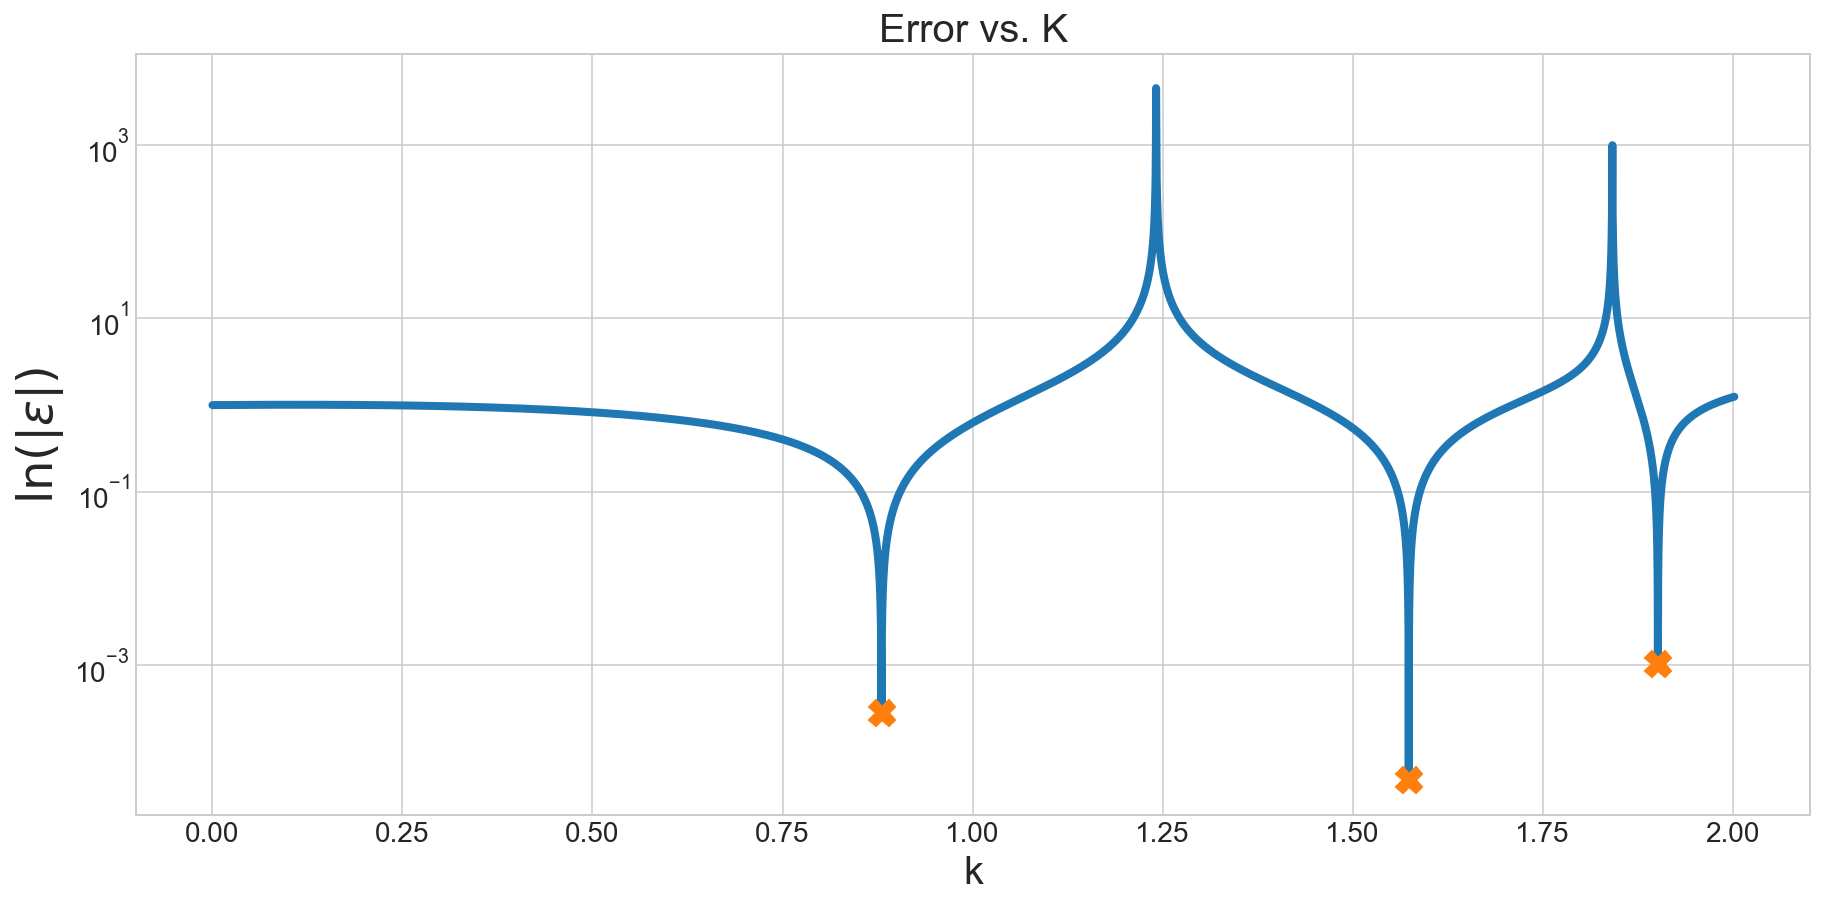

In [5]:
peaks, _ = find_peaks(-np.abs(err_list))
plt.figure(figsize=(15,7))
plt.plot(k_list, np.abs(err_list), lw=4)
plt.plot(k_list[peaks], np.abs(err_list[peaks]), "X", ms=13)
plt.xlabel("k", fontsize=20)
plt.ylabel(r"$\ln(| \epsilon |)$", fontsize=24)
plt.title("Error vs. K", fontsize=20)
plt.yscale("log")
plt.show()

The $\epsilon$ value has three local minima from 0 to $k_max$. But if we plot the wavefunctions obtained from the k value at each of the local minima, only two of them have continuous $\psi$ and $\frac{\partial \psi}{\partial x}$

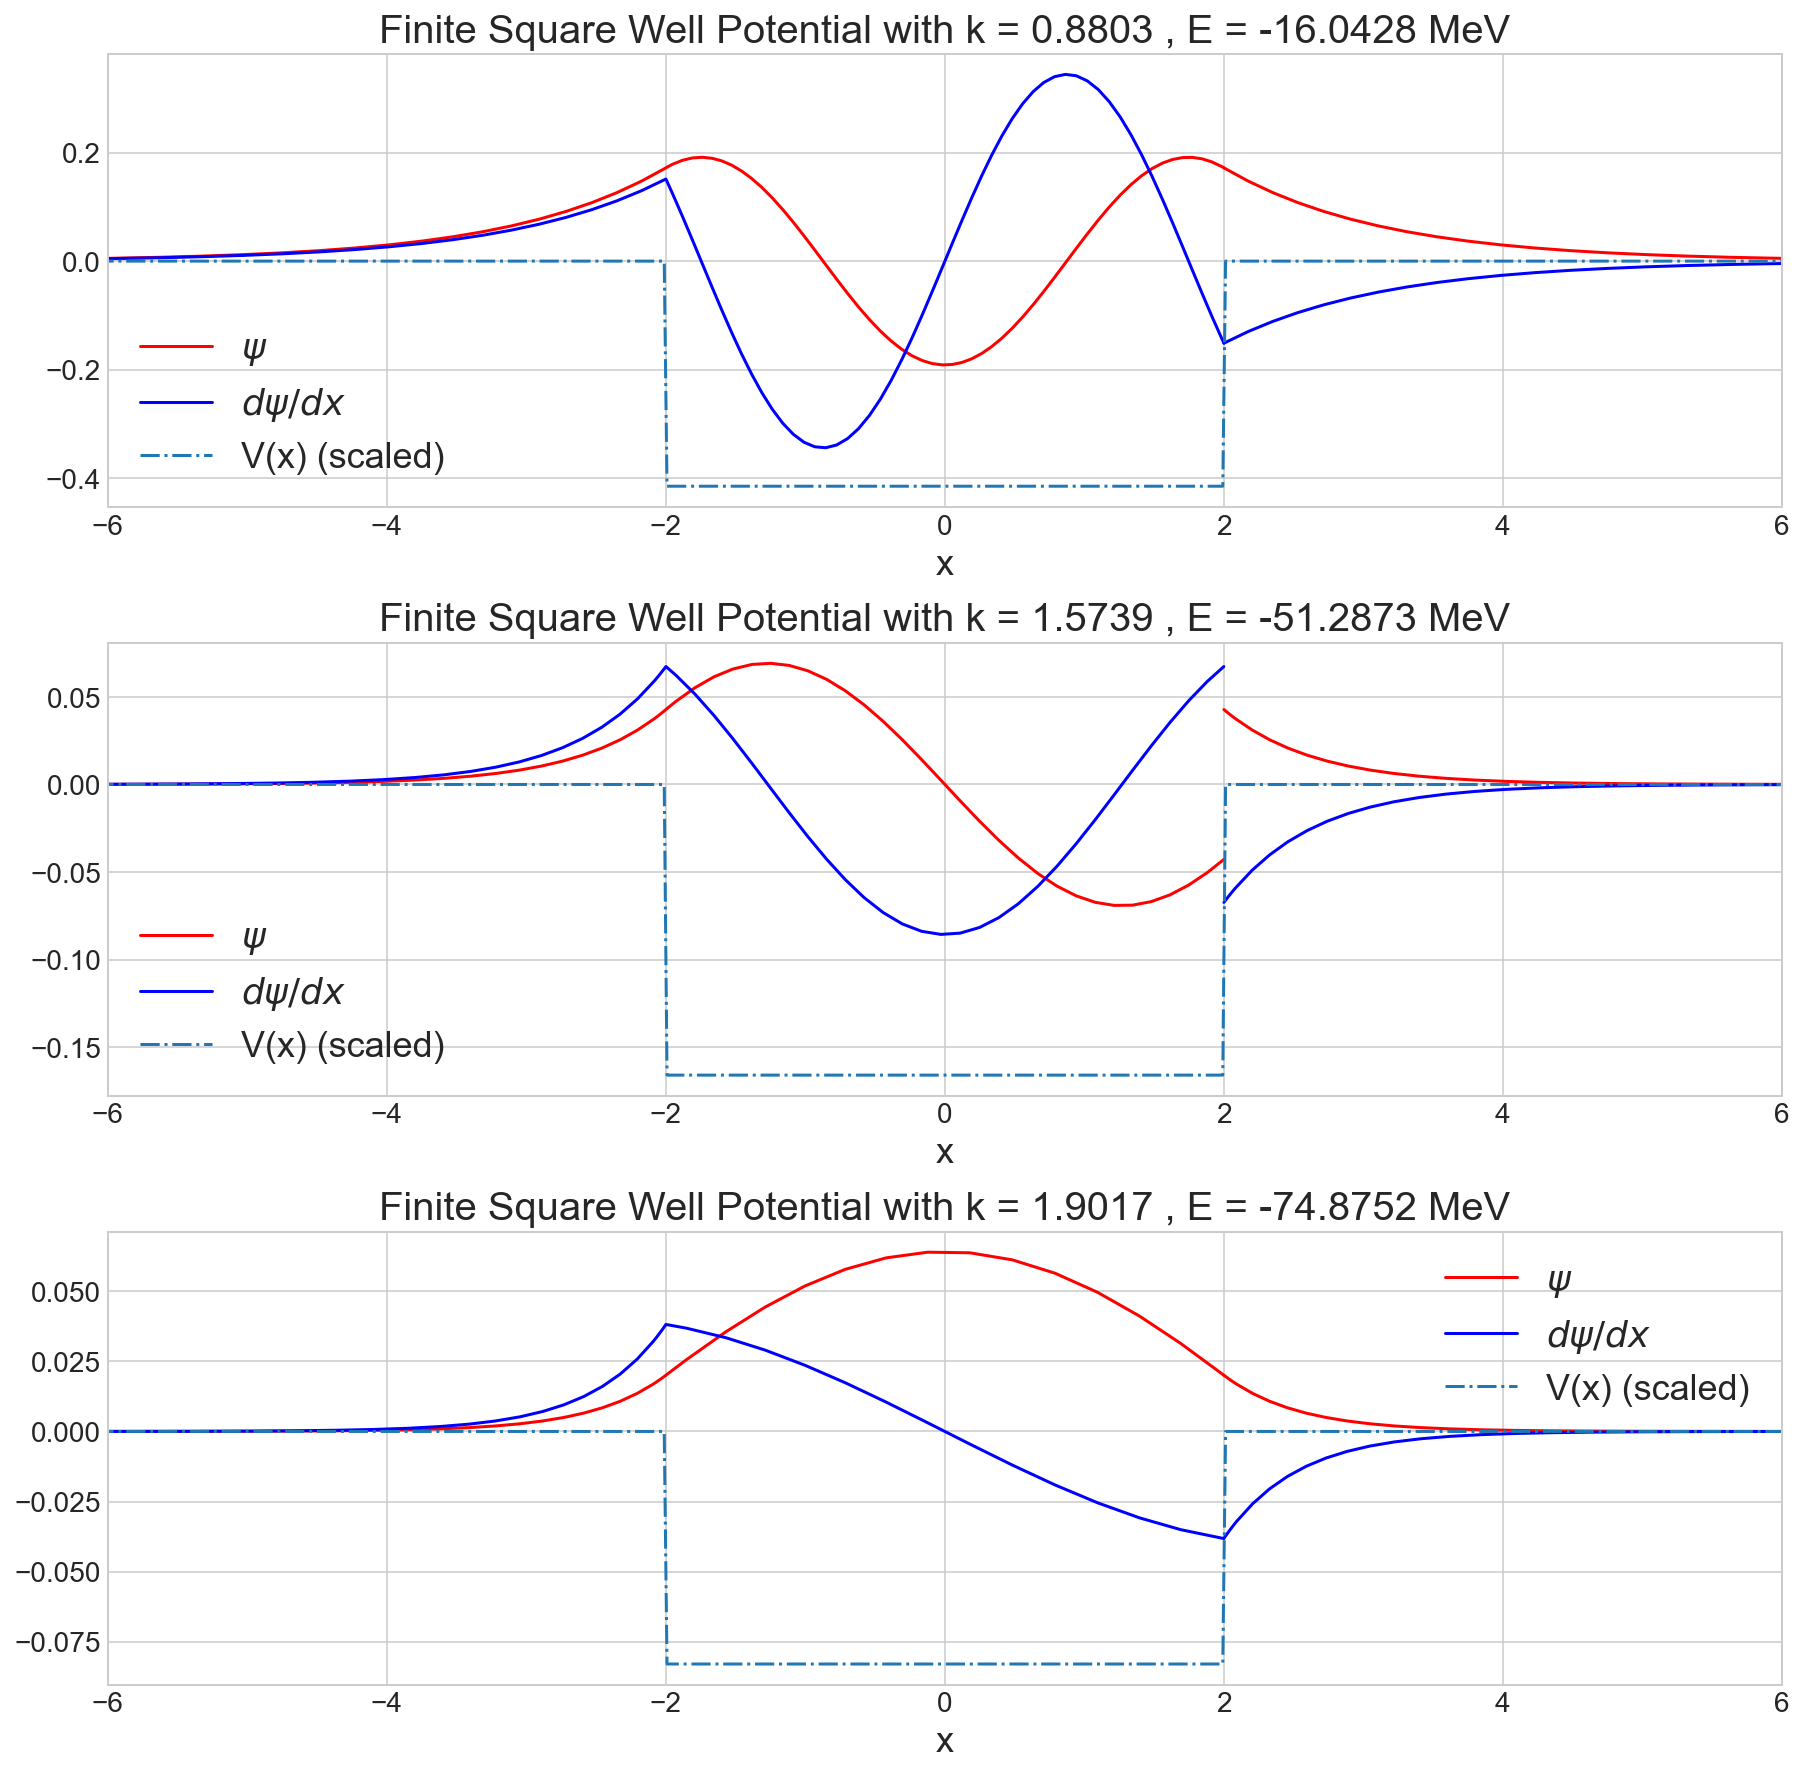

In [9]:
# Plot wavefunctions with optimal k values
k = k_list[peaks[0]] 
E = -(1/α)*k**2
x_L, ψ_L, dψdx_L = get_L_solution(k)
x_R, ψ_R, dψdx_R = get_R_solution(k)
err = (dψdx_L[-1]/ψ_L[-1] - dψdx_R[-1]/ψ_R[-1])/(dψdx_L[-1]/ψ_L[-1] + dψdx_R[-1]/ψ_R[-1])
x = np.linspace(-5*a,5*a,1000)

plt.figure(figsize=(15,15))

plt.subplot(3,1,1)
plt.plot(x_L, ψ_L,"r", label=r"$\psi$")
plt.plot(x_R, ψ_R,"r")
plt.plot(x_L, dψdx_L,"b", label=r"$dψ/dx$")
plt.plot(x_R, dψdx_R,"b")
plt.plot(x, [-V(i)*0.005 for i in x],"-.", label="V(x) (scaled)")
plt.xlabel("x", fontsize=18)
plt.title("Finite Square Well Potential with k = {} , E = {} MeV".format(np.round(k,4), np.round(E,4)), fontsize=20)
plt.xlim([-3*a,3*a])
plt.legend(prop={'size': 18})

k = k_list[peaks[1]] 
E = -(1/α)*k**2
x_L, ψ_L, dψdx_L = get_L_solution(k)
x_R, ψ_R, dψdx_R = get_R_solution(k)
err = (dψdx_L[-1]/ψ_L[-1] - dψdx_R[-1]/ψ_R[-1])/(dψdx_L[-1]/ψ_L[-1] + dψdx_R[-1]/ψ_R[-1])

plt.subplot(3,1,2)
plt.plot(x_L, ψ_L,"r", label=r"$\psi$")
plt.plot(x_R, ψ_R,"r")
plt.plot(x_L, dψdx_L,"b", label=r"$dψ/dx$")
plt.plot(x_R, dψdx_R,"b")
plt.plot(x, [-V(i)*0.002 for i in x],"-.", label="V(x) (scaled)")
plt.xlabel("x", fontsize=18)
plt.title("Finite Square Well Potential with k = {} , E = {} MeV".format(np.round(k,4), np.round(E,4)), fontsize=20)
plt.xlim([-3*a,3*a])
plt.legend(prop={'size': 18})

k = k_list[peaks[2]] 
E = -(1/α)*k**2
x_L, ψ_L, dψdx_L = get_L_solution(k)
x_R, ψ_R, dψdx_R = get_R_solution(k)
err = (dψdx_L[-1]/ψ_L[-1] - dψdx_R[-1]/ψ_R[-1])/(dψdx_L[-1]/ψ_L[-1] + dψdx_R[-1]/ψ_R[-1])

plt.subplot(3,1,3)
plt.plot(x_L, ψ_L,"r", label=r"$\psi$")
plt.plot(x_R, ψ_R,"r")
plt.plot(x_L, dψdx_L,"b", label=r"$dψ/dx$")
plt.plot(x_R, dψdx_R,"b")
plt.plot(x, [-V(i)*0.001 for i in x],"-.", label="V(x) (scaled)")
plt.xlabel("x", fontsize=18)
plt.title("Finite Square Well Potential with k = {} , E = {} MeV".format(np.round(k,4), np.round(E,4)), fontsize=20)
plt.xlim([-3*a,3*a])
plt.legend(prop={'size': 18})

plt.gcf().subplots_adjust(hspace=0.3)
plt.show()

# Question 2

In [12]:
a0 = lambda q: -(1/2)*q**2 + (7/128)*q**4 - (29/2304)*q**6
b1 = lambda q: 1 - q - (1/8)*q**2 + (1/64)*q**3 - (1/1536)*q**4


def deriv(t,y,p,q):
    x, dxdt = y
    return dxdt, -x*(p - 2*q*np.cos(2*t))


def get_solution(p,q,x0,dx0):
    sol = solve_ivp(lambda x,y: deriv(x,y,p,q), t_span=(0,30), y0=[x0,dx0], method="RK45", rtol=1e-13, atol=1e-13)
    t = sol.t
    y = sol.y[0]
    dydt = sol.y[1]
    print("{} timesteps".format(t.shape[0]))
    return t, y, dydt

4718 timesteps
4062 timesteps


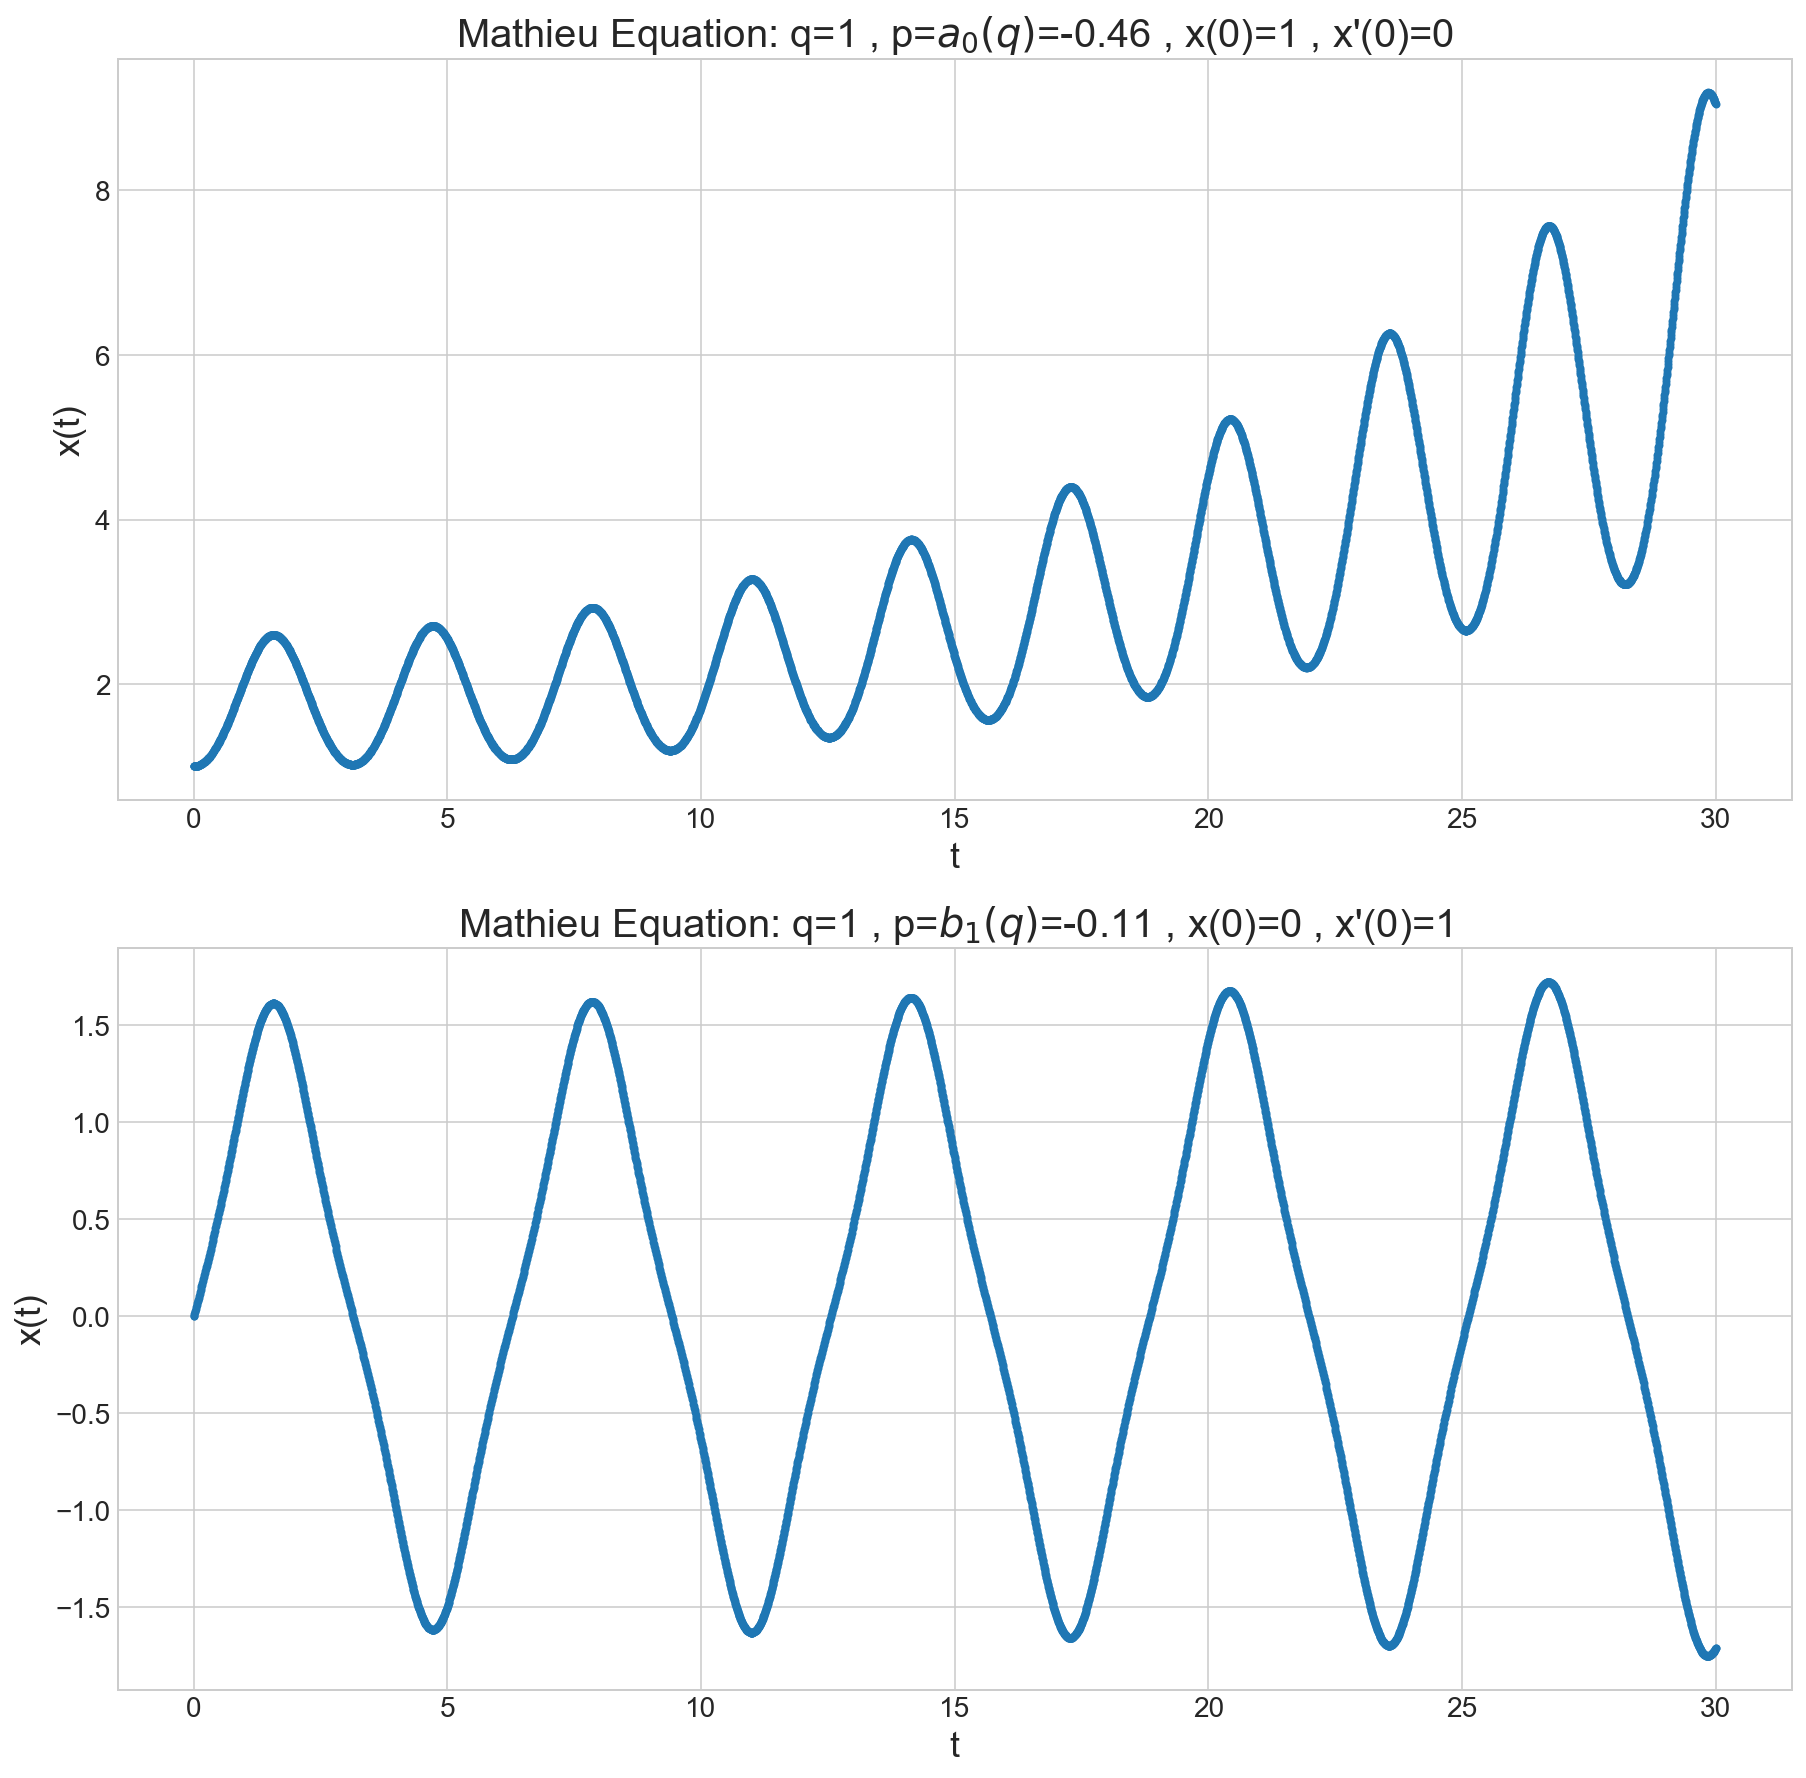

In [13]:
q=1
p=a0(q)
x0=1 
dx0=0
t,x,dxdt = get_solution(p, q, x0, dx0)

plt.figure(figsize=(15,15))

plt.subplot(2,1,1)
plt.plot(t, x, ".-")
plt.ylabel("x(t)", fontsize=18)
plt.xlabel("t", fontsize=18)
plt.title(r"Mathieu Equation: q={} , p=$a_0(q)$={} , x(0)={} , x'(0)={}".format(q,np.round(p,2),x0,dx0), fontsize=20)

q=1
p=b1(q)
x0=0
dx0=1
t,x,dxdt = get_solution(p, q, x0, dx0)

plt.subplot(2,1,2)
plt.plot(t, x, ".-")
plt.ylabel("x(t)", fontsize=18)
plt.xlabel("t", fontsize=18)
plt.title(r"Mathieu Equation: q={} , p=$b_1(q)$={} , x(0)={} , x'(0)={}".format(q,np.round(p,2),x0,dx0), fontsize=20)
plt.show()

From the plots, we see that motion is more complex than a simple harmonic oscillator. In the first plot the oscillations are sinusoidal shaped, drift upward, and increase in amplitude with time. In the second plot the oscillations are more less sinusoidal and more triangular, but the amplitude stays roughly constant. 